## Data Mining: TB and HIV/AIDS Disease Burden Analysis

Part 4: Aime - 232

**Objective**: Apply three mining techniques to uncover patterns in global disease burden data
 
**Mining Techniques**:
1. **Clustering (K-Means)**: Identify countries with similar disease burden profiles
2. **Classification (Decision Tree)**: Predict high-burden locations and understand key factors
3. **Association Rules (Apriori)**: Discover co-occurring patterns in disease characteristics

**Dataset**: Global health data (2000-2013) with ~78,000 records covering Tuberculosis and HIV/AIDS across 195 locations


## 1. Setup and Data Loading


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [7]:
# Load cleaned data
df = pd.read_excel('Group_work_cleaned.xlsx')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (78651, 14)

Column Names:
['location_id', 'location_name', 'year', 'age_group_id', 'age_group_name', 'sex_id', 'sex_name', 'cause_name', 'metric', 'unit', 'mean', 'lower', 'upper', 'upper_deviation_pct']

First few rows:


,location_id,location_name,year,age_group_id,age_group_name,sex_id,sex_name,cause_name,metric,unit,mean,lower,upper,upper_deviation_pct
0,1,Global,2000,27,Age-standardized,1,Males,Tuberculosis,Deaths,"Rate per 100,000",41.000000,37.1,45.5,10.975610
1,1,Global,2000,27,Age-standardized,1,Males,Tuberculosis,Prevalence,"Rate per 100,000",260.299988,252.1,268.6,3.188633
2,1,Global,2000,27,Age-standardized,2,Females,Tuberculosis,Deaths,"Rate per 100,000",22.900000,19.0,24.9,8.733626
3,1,Global,2000,27,Age-standardized,2,Females,Tuberculosis,Prevalence,"Rate per 100,000",123.099998,119.5,126.9,3.086922
4,1,Global,2000,27,Age-standardized,3,Both sexes,Tuberculosis,Deaths,"Rate per 100,000",31.200001,28.4,33.5,7.371792


## 2. Data Preparation for Mining


In [ ]:

# %%
# Create focused dataset for mining
# Separate deaths and prevalence for better analysis
df_deaths = df[df['metric'] == 'Deaths'].copy()
df_prevalence = df[df['metric'] == 'Prevalence'].copy()

print(f"Deaths records: {len(df_deaths)}")
print(f"Prevalence records: {len(df_prevalence)}")

# Create aggregated features by location and disease
location_features = df.groupby(['location_id', 'location_name', 'cause_name']).agg({
    'mean': 'mean',
    'lower': 'mean',
    'upper': 'mean',
    'year': ['min', 'max', 'count']
}).reset_index()

location_features.columns = ['location_id', 'location_name', 'cause_name', 
                              'avg_mean', 'avg_lower', 'avg_upper', 
                              'year_min', 'year_max', 'record_count']

print(f"\nAggregated location features shape: {location_features.shape}")
location_features.head()

Deaths records: 63742
Prevalence records: 14822

Aggregated location features shape: (98, 9)


,location_id,location_name,cause_name,avg_mean,avg_lower,avg_upper,year_min,year_max,record_count
0,1,Global,HIV/AIDS,536.030555,436.841667,651.322222,2000,2013,72
1,1,Global,Tuberculosis,58.676364,55.200000,61.809091,2000,2013,55
2,139,Algeria,HIV/AIDS,77.736102,40.289457,132.008786,2000,2013,626
3,139,Algeria,Tuberculosis,250.642281,206.260949,296.054087,2000,2013,991
4,141,Egypt,HIV/AIDS,57.894454,36.568739,83.254118,2000,2013,595


## 3. Mining Technique 1: K-Means Clustering

**Goal**: Group countries by disease burden patterns to identify regions with similar health challenges

**Features Used**: Average mortality/prevalence rates, uncertainty ranges, and data completeness

In [11]:
# Prepare data for clustering - pivot to get TB and HIV features per location
clustering_data = location_features.pivot_table(
    index=['location_id', 'location_name'],
    columns='cause_name',
    values=['avg_mean', 'avg_upper', 'record_count']
).reset_index()

# Flatten column names
clustering_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                           for col in clustering_data.columns.values]

# Fill missing values with 0 (locations without certain disease data)
clustering_features = clustering_data.select_dtypes(include=[np.number]).fillna(0)

print(f"Clustering dataset shape: {clustering_features.shape}")
clustering_features.head()

Clustering dataset shape: (49, 7)


,location_id,avg_mean_HIV/AIDS,avg_mean_Tuberculosis,avg_upper_HIV/AIDS,avg_upper_Tuberculosis,record_count_HIV/AIDS,record_count_Tuberculosis
0,1,536.030555,58.676364,651.322222,61.809091,72.0,55.0
1,139,77.736102,250.642281,132.008786,296.054087,626.0,991.0
2,141,57.894454,243.992812,83.254118,283.175625,595.0,960.0
3,147,16.014943,63.892260,27.768966,70.431269,174.0,646.0
4,148,94.440507,301.905051,140.629747,362.412121,632.0,990.0


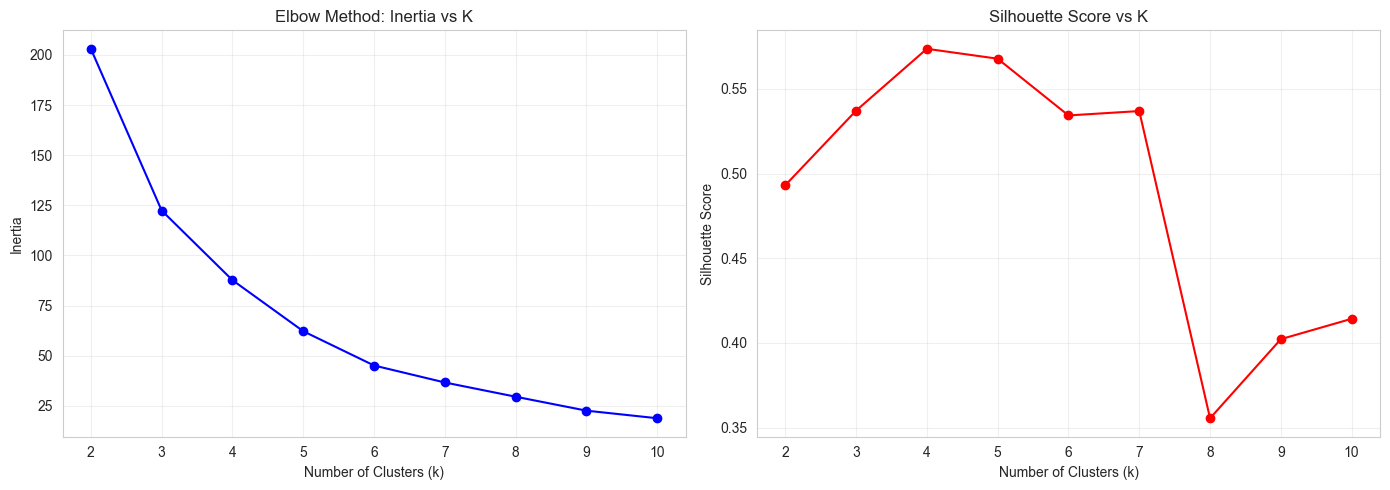


Optimal k based on silhouette score: 4


In [12]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Find optimal k using elbow method and silhouette score
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method: Inertia vs K')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k}")


In [13]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_data['cluster'] = kmeans.fit_predict(scaled_features)

# Merge with location names
clustering_results = clustering_data[['location_id', 'location_name', 'cluster']].copy()

# Analyze cluster characteristics
cluster_summary = clustering_data.groupby('cluster').agg({
    'avg_mean_HIV/AIDS': 'mean',
    'avg_mean_Tuberculosis': 'mean',
    'record_count_HIV/AIDS': 'mean',
    'record_count_Tuberculosis': 'mean'
}).round(2)

print("\n=== Cluster Characteristics ===")
print(cluster_summary)

# Show sample countries in each cluster
print("\n=== Sample Countries per Cluster ===")
for cluster_id in sorted(clustering_results['cluster'].unique()):
    countries = clustering_results[clustering_results['cluster'] == cluster_id]['location_name'].head(10).tolist()
    print(f"\nCluster {cluster_id}: {', '.join(countries)}")



=== Cluster Characteristics ===
         avg_mean_HIV/AIDS  avg_mean_Tuberculosis  record_count_HIV/AIDS  \
cluster                                                                    
0                  1036.48                 789.26                 506.70   
1                   360.86                 254.76                 859.74   
2                   118.34                  53.51                 205.67   
3                   346.74                 337.04                 885.00   

         record_count_Tuberculosis  
cluster                             
0                           856.80  
1                           984.90  
2                           474.17  
3                           991.50  

=== Sample Countries per Cluster ===

Cluster 0: Ethiopia, Kenya, Malawi, Mozambique, Tanzania, Uganda, Zambia, South Africa, Zimbabwe, Nigeria

Cluster 1: Algeria, Egypt, Morocco, Angola, Central African Republic, Congo, Equatorial Guinea, Gabon, Burundi, Djibouti

Cluster 2: Global, L

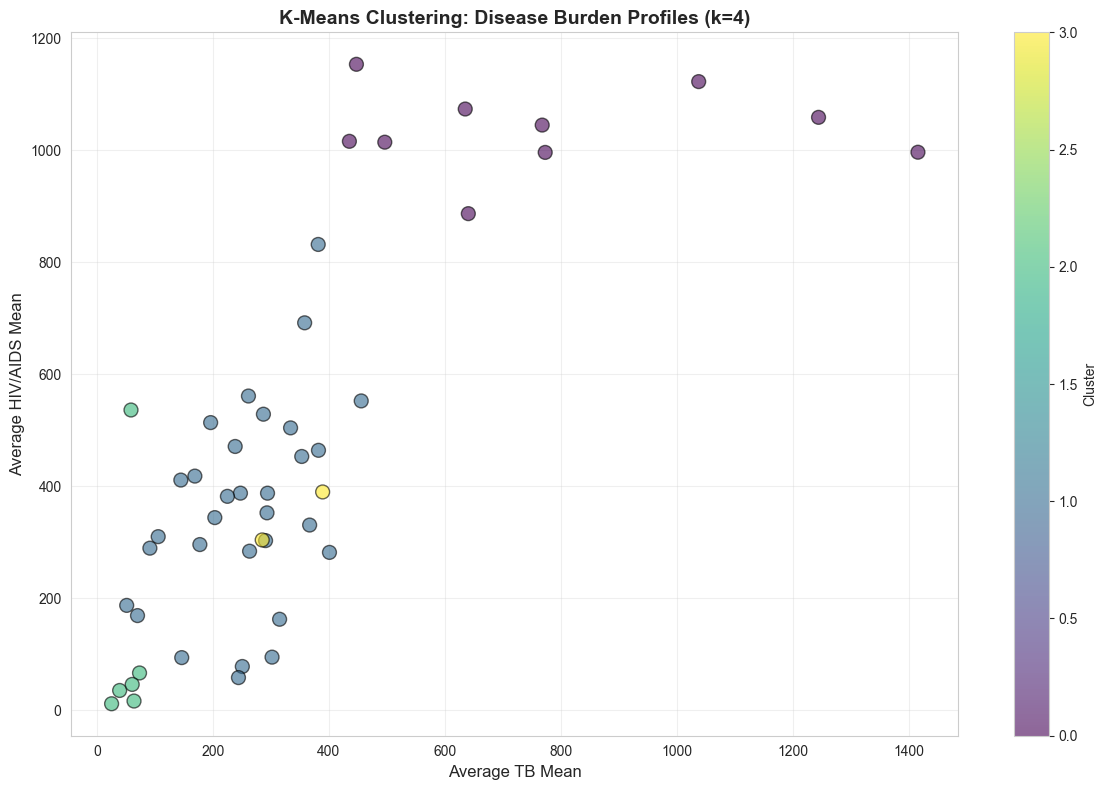

In [14]:
# Visualize clusters
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

scatter = ax.scatter(
    clustering_data['avg_mean_Tuberculosis'],
    clustering_data['avg_mean_HIV/AIDS'],
    c=clustering_data['cluster'],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)

ax.set_xlabel('Average TB Mean', fontsize=12)
ax.set_ylabel('Average HIV/AIDS Mean', fontsize=12)
ax.set_title(f'K-Means Clustering: Disease Burden Profiles (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Mining Technique 2: Decision Tree Classification
 
**Goal**: Predict high-burden locations and identify key factors that distinguish them
 
**Target**: Binary classification of high vs. low disease burden based on mean values


In [15]:
# Prepare classification dataset - use age-standardized rates for fair comparison
class_data = df[
    (df['age_group_name'] == 'Age-standardized') & 
    (df['metric'] == 'Deaths') &
    (df['unit'] == 'Rate per 100,000')
].copy()

# Create features
class_features = class_data.groupby(['location_id', 'location_name']).agg({
    'mean': 'mean',
    'upper': 'mean',
    'lower': 'mean',
    'year': 'count'
}).reset_index()

class_features.columns = ['location_id', 'location_name', 'avg_death_rate', 
                          'avg_upper_bound', 'avg_lower_bound', 'num_records']

# Add disease-specific features
tb_rates = class_data[class_data['cause_name'] == 'Tuberculosis'].groupby('location_id')['mean'].mean()
hiv_rates = class_data[class_data['cause_name'] == 'HIV/AIDS'].groupby('location_id')['mean'].mean()

class_features['tb_death_rate'] = class_features['location_id'].map(tb_rates).fillna(0)
class_features['hiv_death_rate'] = class_features['location_id'].map(hiv_rates).fillna(0)
class_features['uncertainty_range'] = class_features['avg_upper_bound'] - class_features['avg_lower_bound']

# Create binary target: high burden = above 75th percentile
threshold = class_features['avg_death_rate'].quantile(0.75)
class_features['high_burden'] = (class_features['avg_death_rate'] > threshold).astype(int)

print(f"High burden threshold: {threshold:.2f} deaths per 100,000")
print(f"High burden locations: {class_features['high_burden'].sum()}")
print(f"Low burden locations: {(1 - class_features['high_burden']).sum()}")

class_features.head()

High burden threshold: 182.39 deaths per 100,000
High burden locations: 12
Low burden locations: 37


,location_id,location_name,avg_death_rate,avg_upper_bound,avg_lower_bound,num_records,tb_death_rate,hiv_death_rate,uncertainty_range,high_burden
0,1,Global,24.379762,26.905952,21.889286,84,25.028571,23.730952,5.016667,0
1,139,Algeria,9.452381,11.688095,6.916667,42,9.452381,0.000000,4.771429,0
2,141,Egypt,3.200000,3.900000,2.837500,8,3.200000,0.000000,1.062500,0
3,147,Libya,2.942857,3.714286,2.271429,14,2.942857,0.000000,1.442857,0
4,148,Morocco,19.135714,23.561905,14.807143,42,19.135714,0.000000,8.754762,0


In [16]:
# Prepare features and target
X = class_features[['tb_death_rate', 'hiv_death_rate', 'uncertainty_range', 'num_records']]
y = class_features['high_burden']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train decision tree
dt_classifier = DecisionTreeClassifier(
    max_depth=4, 
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_classifier.fit(X_train, y_train)

# Predictions
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== Decision Tree Performance ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Burden', 'High Burden']))


=== Decision Tree Performance ===
Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

  Low Burden       1.00      1.00      1.00        11
 High Burden       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



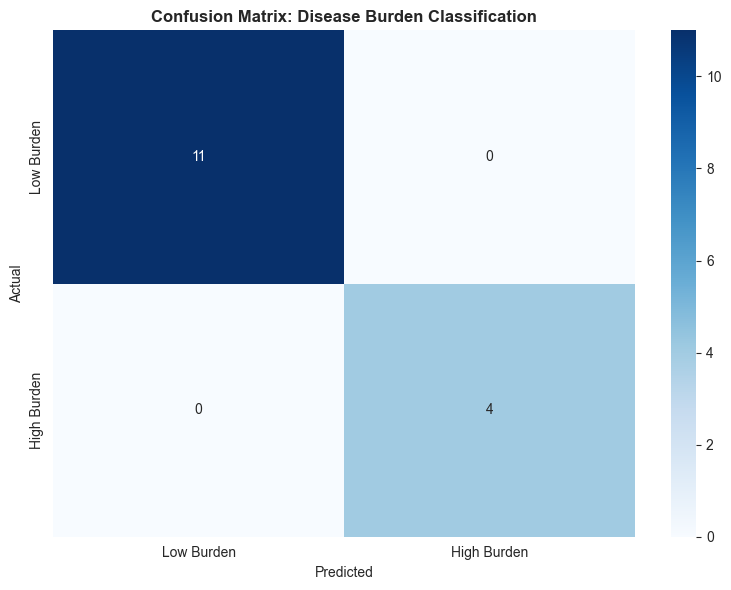

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Burden', 'High Burden'],
            yticklabels=['Low Burden', 'High Burden'])
plt.title('Confusion Matrix: Disease Burden Classification', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

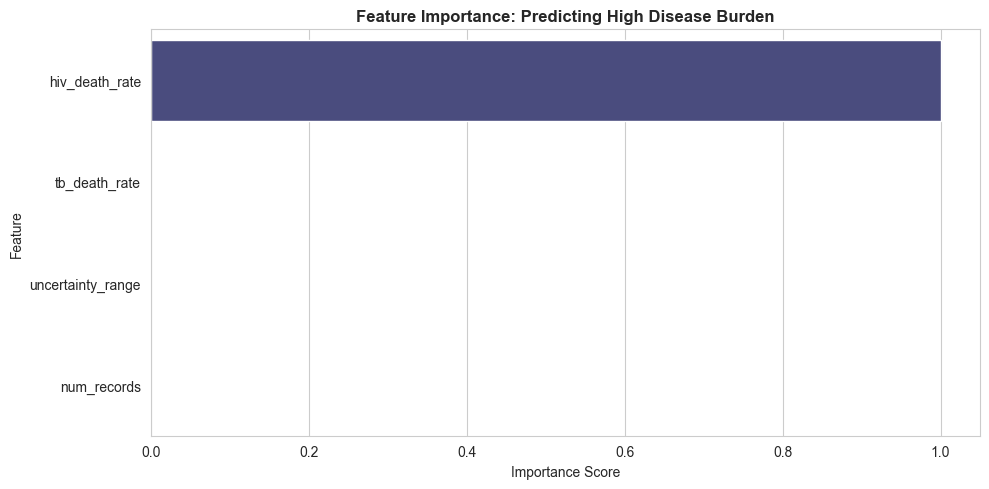


=== Feature Importance ===
             feature  importance
1     hiv_death_rate         1.0
0      tb_death_rate         0.0
2  uncertainty_range         0.0
3        num_records         0.0


In [18]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance: Predicting High Disease Burden', fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n=== Feature Importance ===")
print(feature_importance)

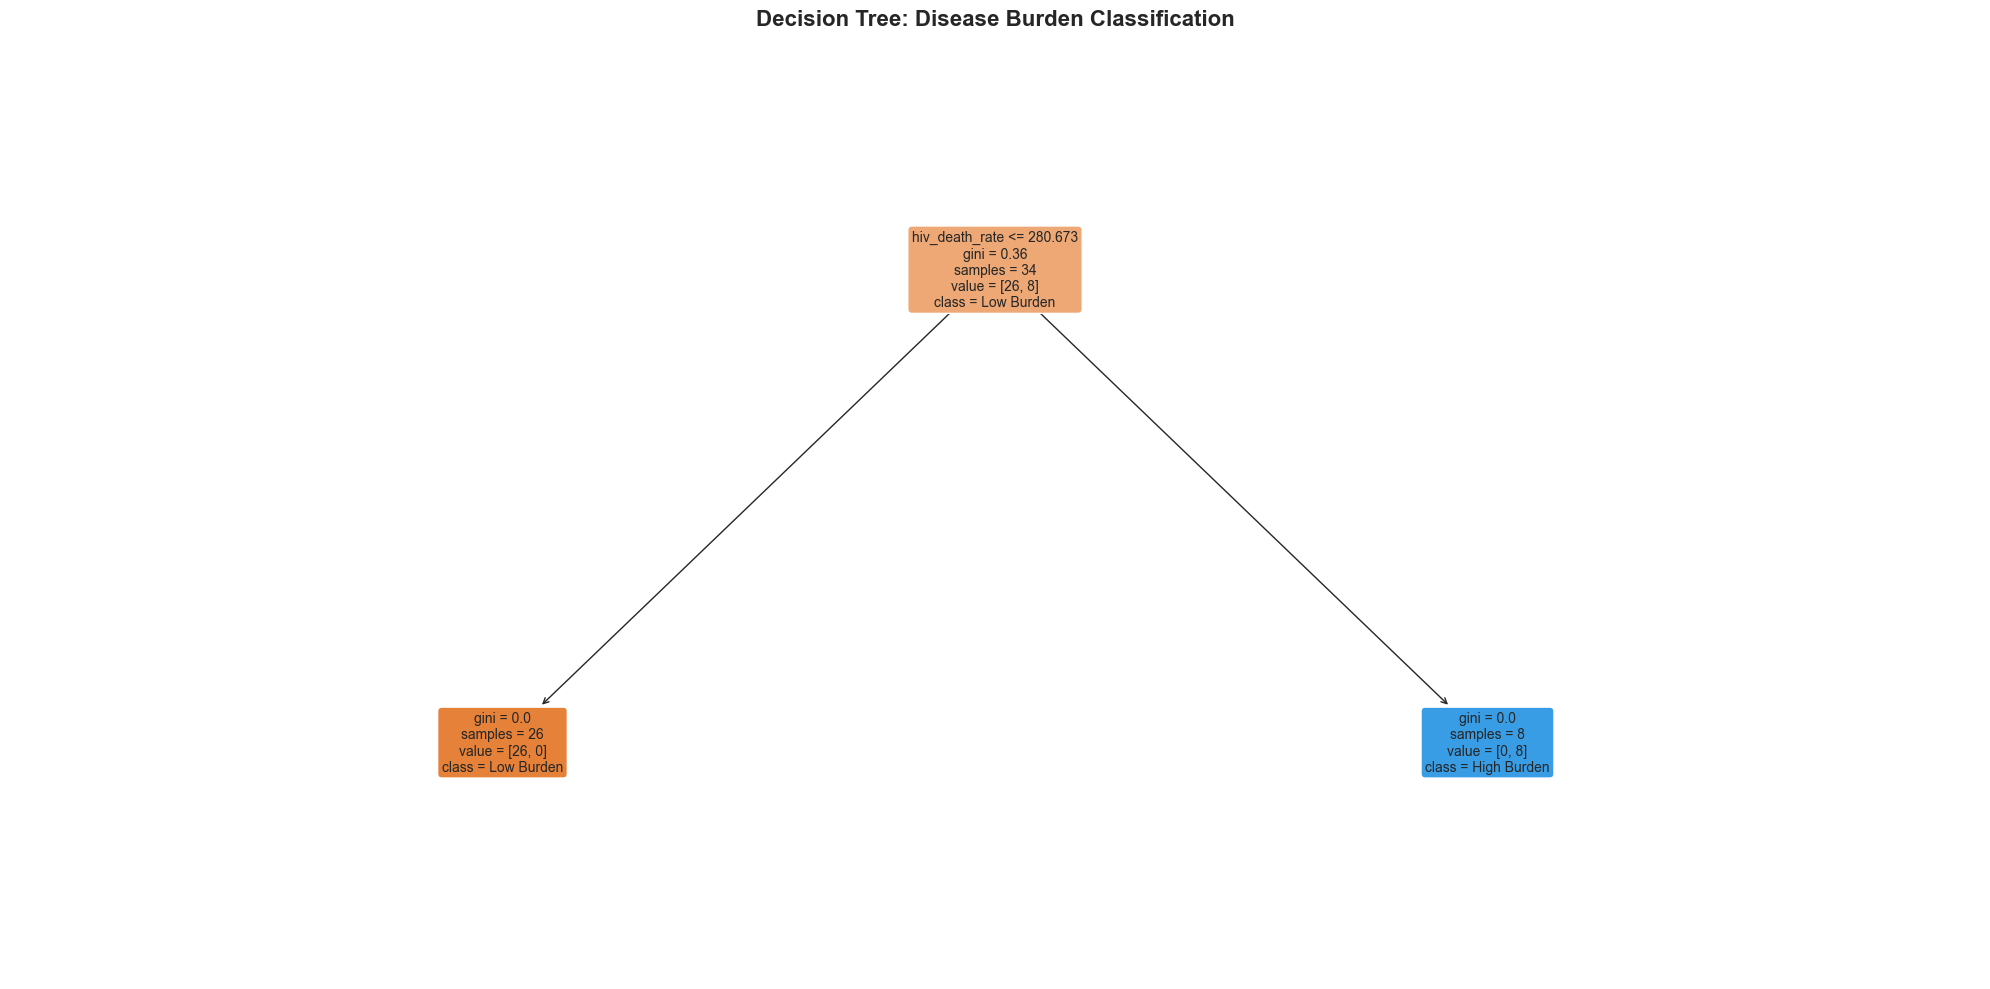

In [19]:
# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, 
          feature_names=X.columns,
          class_names=['Low Burden', 'High Burden'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree: Disease Burden Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Mining Technique 3: Association Rules (Market Basket Analysis)

**Goal**: Discover patterns in how disease characteristics co-occur (e.g., age groups, sex, disease types)

**Method**: Apriori algorithm to find frequent itemsets and generate association rules


In [20]:
# Prepare transaction data - each transaction is a unique location-year-disease combination
# Create categorical bins for analysis
assoc_data = df[df['metric'] == 'Deaths'].copy()

# Categorize death rates
assoc_data['rate_category'] = pd.cut(
    assoc_data['mean'],
    bins=[0, 10, 50, 200, np.inf],
    labels=['Very_Low', 'Low', 'Medium', 'High']
)

# Create transaction items
assoc_data['disease_item'] = assoc_data['cause_name'].str.replace('/', '_').str.replace(' ', '_')
assoc_data['sex_item'] = 'Sex_' + assoc_data['sex_name']
assoc_data['age_item'] = 'Age_' + assoc_data['age_group_name'].str.replace(' ', '_')
assoc_data['rate_item'] = 'Rate_' + assoc_data['rate_category'].astype(str)
assoc_data['year_period'] = pd.cut(
    assoc_data['year'],
    bins=[1999, 2005, 2010, 2014],
    labels=['Period_2000-2005', 'Period_2006-2010', 'Period_2011-2013']
)
assoc_data['period_item'] = assoc_data['year_period'].astype(str)

# Create transactions (list of items per record)
transactions = []
for _, row in assoc_data.iterrows():
    transaction = [
        row['disease_item'],
        row['sex_item'],
        row['age_item'],
        row['rate_item'],
        row['period_item']
    ]
    transactions.append([item for item in transaction if pd.notna(item)])

print(f"Number of transactions: {len(transactions)}")
print(f"Sample transaction: {transactions[0]}")

Number of transactions: 63742
Sample transaction: ['Tuberculosis', 'Sex_Males', 'Age_Age-standardized', 'Rate_Low', 'Period_2000-2005']


In [21]:
# Encode transactions for apriori
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

print(f"Encoded dataset shape: {df_encoded.shape}")
print(f"Number of unique items: {len(te.columns_)}")

Encoded dataset shape: (63742, 31)
Number of unique items: 31


In [22]:
# Apply Apriori algorithm
min_support = 0.05  # At least 5% of transactions
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"\n=== Frequent Itemsets (min support = {min_support}) ===")
print(f"Total frequent itemsets found: {len(frequent_itemsets)}")
print(f"\nItemset size distribution:")
print(frequent_itemsets['length'].value_counts().sort_index())

# Show top itemsets by support
print(f"\nTop 15 Most Frequent Itemsets:")
top_itemsets = frequent_itemsets.nlargest(15, 'support')[['itemsets', 'support', 'length']]
for idx, row in top_itemsets.iterrows():
    items = ', '.join(row['itemsets'])
    print(f"Support: {row['support']:.3f} | Items: {items}")


=== Frequent Itemsets (min support = 0.05) ===
Total frequent itemsets found: 105

Itemset size distribution:
length
1    30
2    44
3    31
Name: count, dtype: int64

Top 15 Most Frequent Itemsets:
Support: 0.545 | Items: Tuberculosis
Support: 0.455 | Items: HIV_AIDS
Support: 0.426 | Items: Period_2000-2005
Support: 0.382 | Items: Rate_High
Support: 0.357 | Items: Period_2006-2010
Support: 0.340 | Items: Sex_Males
Support: 0.333 | Items: Sex_Females
Support: 0.327 | Items: Sex_Both sexes
Support: 0.322 | Items: Rate_Medium
Support: 0.234 | Items: Period_2000-2005, Tuberculosis
Support: 0.216 | Items: Period_2011-2013
Support: 0.209 | Items: Rate_Low
Support: 0.199 | Items: Rate_Medium, Tuberculosis
Support: 0.198 | Items: Rate_High, HIV_AIDS
Support: 0.195 | Items: Period_2006-2010, Tuberculosis


In [23]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

# Calculate lift (already included but let's highlight it)
rules = rules.sort_values('lift', ascending=False)

print(f"\n=== Association Rules (min confidence = 0.6) ===")
print(f"Total rules found: {len(rules)}")


=== Association Rules (min confidence = 0.6) ===
Total rules found: 6


In [24]:
# Display top rules by different metrics
print("\n=== Top 10 Rules by Lift (Strength of Association) ===")
top_lift = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
for idx, row in top_lift.iterrows():
    ant = ', '.join(row['antecedents'])
    cons = ', '.join(row['consequents'])
    print(f"\nIF {ant}")
    print(f"THEN {cons}")
    print(f"Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")

print("\n=== Top 10 Rules by Confidence (Certainty) ===")
top_conf = rules.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
for idx, row in top_conf.iterrows():
    ant = ', '.join(row['antecedents'])
    cons = ', '.join(row['consequents'])
    print(f"\nIF {ant}")
    print(f"THEN {cons}")
    print(f"Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")



=== Top 10 Rules by Lift (Strength of Association) ===

IF Sex_Males, Rate_Medium
THEN Tuberculosis
Support: 0.073 | Confidence: 0.633 | Lift: 1.162

IF Period_2000-2005, Rate_Medium
THEN Tuberculosis
Support: 0.087 | Confidence: 0.630 | Lift: 1.156

IF Rate_Medium
THEN Tuberculosis
Support: 0.199 | Confidence: 0.619 | Lift: 1.135

IF Rate_Medium, Sex_Females
THEN Tuberculosis
Support: 0.068 | Confidence: 0.616 | Lift: 1.129

IF Period_2006-2010, Rate_Medium
THEN Tuberculosis
Support: 0.071 | Confidence: 0.615 | Lift: 1.128

IF Sex_Both sexes, Rate_Medium
THEN Tuberculosis
Support: 0.058 | Confidence: 0.605 | Lift: 1.110

=== Top 10 Rules by Confidence (Certainty) ===

IF Sex_Males, Rate_Medium
THEN Tuberculosis
Support: 0.073 | Confidence: 0.633 | Lift: 1.162

IF Period_2000-2005, Rate_Medium
THEN Tuberculosis
Support: 0.087 | Confidence: 0.630 | Lift: 1.156

IF Rate_Medium
THEN Tuberculosis
Support: 0.199 | Confidence: 0.619 | Lift: 1.135

IF Rate_Medium, Sex_Females
THEN Tuberculos

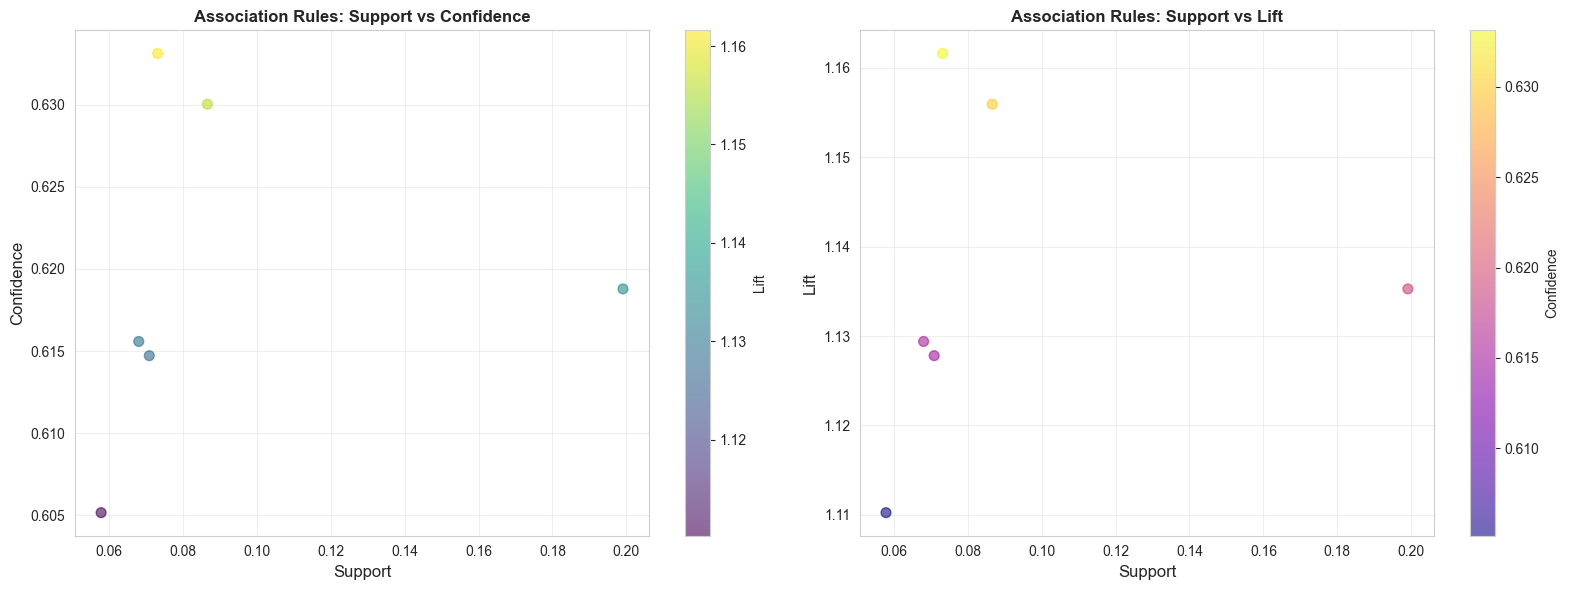

In [25]:
# Visualize association rules
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Support vs Confidence
scatter1 = axes[0].scatter(rules['support'], rules['confidence'], 
                           c=rules['lift'], s=50, alpha=0.6, cmap='viridis')
axes[0].set_xlabel('Support', fontsize=12)
axes[0].set_ylabel('Confidence', fontsize=12)
axes[0].set_title('Association Rules: Support vs Confidence', fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Lift')

# Support vs Lift
scatter2 = axes[1].scatter(rules['support'], rules['lift'], 
                           c=rules['confidence'], s=50, alpha=0.6, cmap='plasma')
axes[1].set_xlabel('Support', fontsize=12)
axes[1].set_ylabel('Lift', fontsize=12)
axes[1].set_title('Association Rules: Support vs Lift', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Confidence')

plt.tight_layout()
plt.show()

In [26]:
# Filter for interpretable rules (disease-related patterns)
disease_rules = rules[
    rules['antecedents'].apply(lambda x: any('HIV' in item or 'Tuberculosis' in item for item in x)) |
    rules['consequents'].apply(lambda x: any('HIV' in item or 'Tuberculosis' in item for item in x))
].nlargest(10, 'lift')

print("\n=== Key Disease-Related Association Rules ===")
for idx, row in disease_rules.iterrows():
    ant = ', '.join(row['antecedents'])
    cons = ', '.join(row['consequents'])
    print(f"\nRule: IF {ant} → THEN {cons}")
    print(f"Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.2f}")


=== Key Disease-Related Association Rules ===

Rule: IF Sex_Males, Rate_Medium → THEN Tuberculosis
Support: 0.073 | Confidence: 0.633 | Lift: 1.16

Rule: IF Period_2000-2005, Rate_Medium → THEN Tuberculosis
Support: 0.087 | Confidence: 0.630 | Lift: 1.16

Rule: IF Rate_Medium → THEN Tuberculosis
Support: 0.199 | Confidence: 0.619 | Lift: 1.14

Rule: IF Rate_Medium, Sex_Females → THEN Tuberculosis
Support: 0.068 | Confidence: 0.616 | Lift: 1.13

Rule: IF Period_2006-2010, Rate_Medium → THEN Tuberculosis
Support: 0.071 | Confidence: 0.615 | Lift: 1.13

Rule: IF Sex_Both sexes, Rate_Medium → THEN Tuberculosis
Support: 0.058 | Confidence: 0.605 | Lift: 1.11
